First we build the Hamiltonian we want in Qiskit

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.synthesis import LieTrotter
from qiskit import qasm3, transpile
from qiskit_addon_cutting.utils.simulation import ExactSampler

from qiskit_ibm_runtime.options import EstimatorOptions, DynamicalDecouplingOptions
from qiskit_ibm_runtime import EstimatorV2, Batch, SamplerV2
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_addon_cutting import partition_problem, generate_cutting_experiments, reconstruct_expectation_values

import csv
import numpy as np
import matplotlib.pyplot as plt
import json


In [2]:
def build_hamiltonian(num_spins, coupling_map, anisotropy = 1, h = 1):

    edge_list = coupling_map.get_edges()
    hamlist = []

    for edge in edge_list:
        hamlist.append(('XX', edge, anisotropy))
        # hamlist.append(('YY', edge, anisotropy)) Work to be able to run this
    for qubit in coupling_map.physical_qubits:
        # hamlist.append(('Y', [qubit], h))
        hamlist.append(('Z', [qubit], h))
    hamiltonian = SparsePauliOp.from_sparse_list(hamlist, num_qubits= num_spins)
    return hamiltonian
 

In [3]:
num_spins = 8  # Number of qubits per ring
num_rings = 2  # Total number of rings
# Generate edges
edges = [
    (ring * num_spins + i, ring * num_spins + (i + 1) % num_spins)
    for ring in range(num_rings)
    for i in range(num_spins)
]
edges.append((0, 2*num_spins-1))


coupling_map = CouplingMap(edges)
#coupling_map.draw()

In [4]:
# Hamiltonian and evolution parameters
num_qubits = num_rings * num_spins
anisotropy = 1.
h = 1.
dt = Parameter('δt')
trotter_reps = 1
dt = 0.1

H = build_hamiltonian(num_qubits, coupling_map, anisotropy, h)

trotterizator = LieTrotter(reps = trotter_reps, insert_barriers=False)
U = PauliEvolutionGate(operator = H, time = dt)
evolutionQC = trotterizator.synthesize(U)

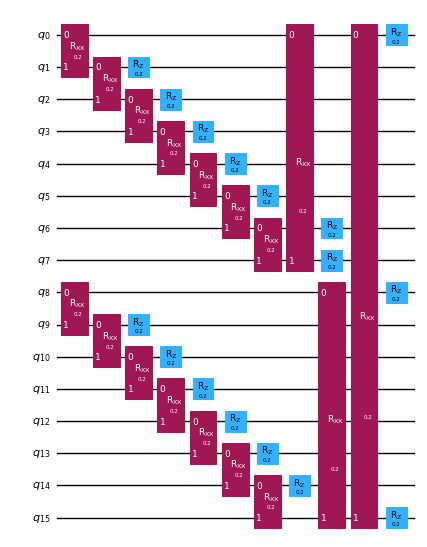

In [5]:
evolutionQC.draw('mpl', scale = 0.5)

In [6]:
z_list = [('Z', [i], 1.) for i in range(num_qubits)]
z_observables = SparsePauliOp.from_sparse_list(z_list, num_qubits = num_qubits)
print(z_observables)

SparsePauliOp(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [7]:
cutting_labels = num_spins * 'A' + num_spins * 'B'
partitioned_problem = partition_problem(circuit = evolutionQC, partition_labels = cutting_labels, observables = z_observables.paulis)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

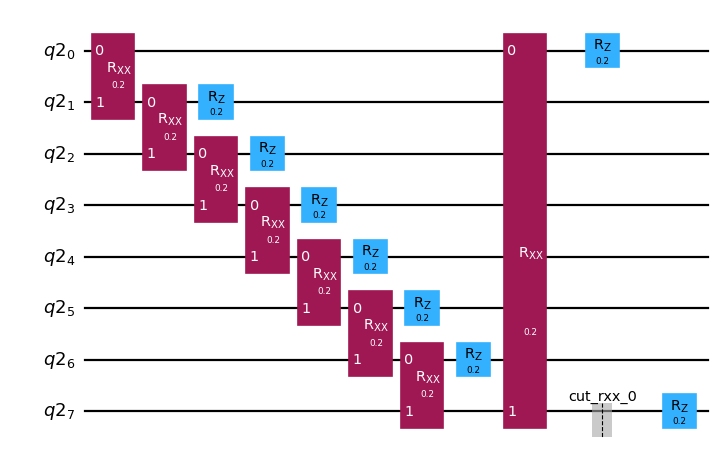

In [8]:
subcircuits["A"].draw("mpl", scale = 0.8, fold = False)
subcircuits["B"].draw("mpl", scale = 0.8, fold = False)

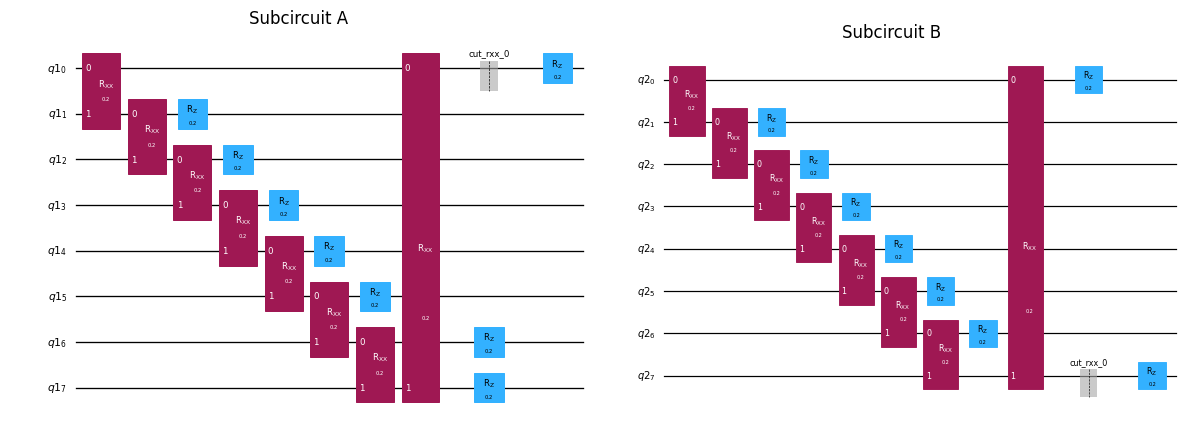

In [9]:

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Draw the first subcircuit on the first axis
subcircuits["A"].draw("mpl", scale=0.8, fold=False, ax=axs[0])
axs[0].set_title("Subcircuit A")

# Draw the second subcircuit on the second axis
subcircuits["B"].draw("mpl", scale=0.8, fold=False, ax=axs[1])
axs[1].set_title("Subcircuit B")

# Adjust layout for better spacing
plt.tight_layout()

# Display both plots in the same cell
plt.show()


In [10]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 1.9525553351744753


In [11]:
subexperiments, coefficients = generate_cutting_experiments(circuits = subcircuits, observables = subobservables, num_samples = np.inf)

In [12]:
print(subobservables)

{'A': PauliList(['IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII',
           'IIZIIIII', 'IZIIIIII', 'ZIIIIIII', 'IIIIIIII', 'IIIIIIII',
           'IIIIIIII', 'IIIIIIII', 'IIIIIIII', 'IIIIIIII', 'IIIIIIII',
           'IIIIIIII']), 'B': PauliList(['IIIIIIII', 'IIIIIIII', 'IIIIIIII', 'IIIIIIII', 'IIIIIIII',
           'IIIIIIII', 'IIIIIIII', 'IIIIIIII', 'IIIIIIIZ', 'IIIIIIZI',
           'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII',
           'ZIIIIIII'])}


In [13]:
from qiskit_aer.primitives import Sampler

exact_sampler = ExactSampler()

results = {
    label: exact_sampler.run(subexperiment).result()
    for label, subexperiment in subexperiments.items()
}


In [14]:
print(coefficients)

[(0.9900332889206209, <WeightType.EXACT: 1>), (0.09933466539753062, <WeightType.EXACT: 1>), (-0.09933466539753062, <WeightType.EXACT: 1>), (0.09933466539753062, <WeightType.EXACT: 1>), (-0.09933466539753062, <WeightType.EXACT: 1>), (0.009966711079379185, <WeightType.EXACT: 1>)]


In [15]:
reconstructed_expval_terms = reconstruct_expectation_values(results, coefficients, subobservables)
reconstructed_expval = np.dot(reconstructed_expval_terms, z_observables.coeffs)
print(reconstructed_expval)

(15.33019463223696+0j)


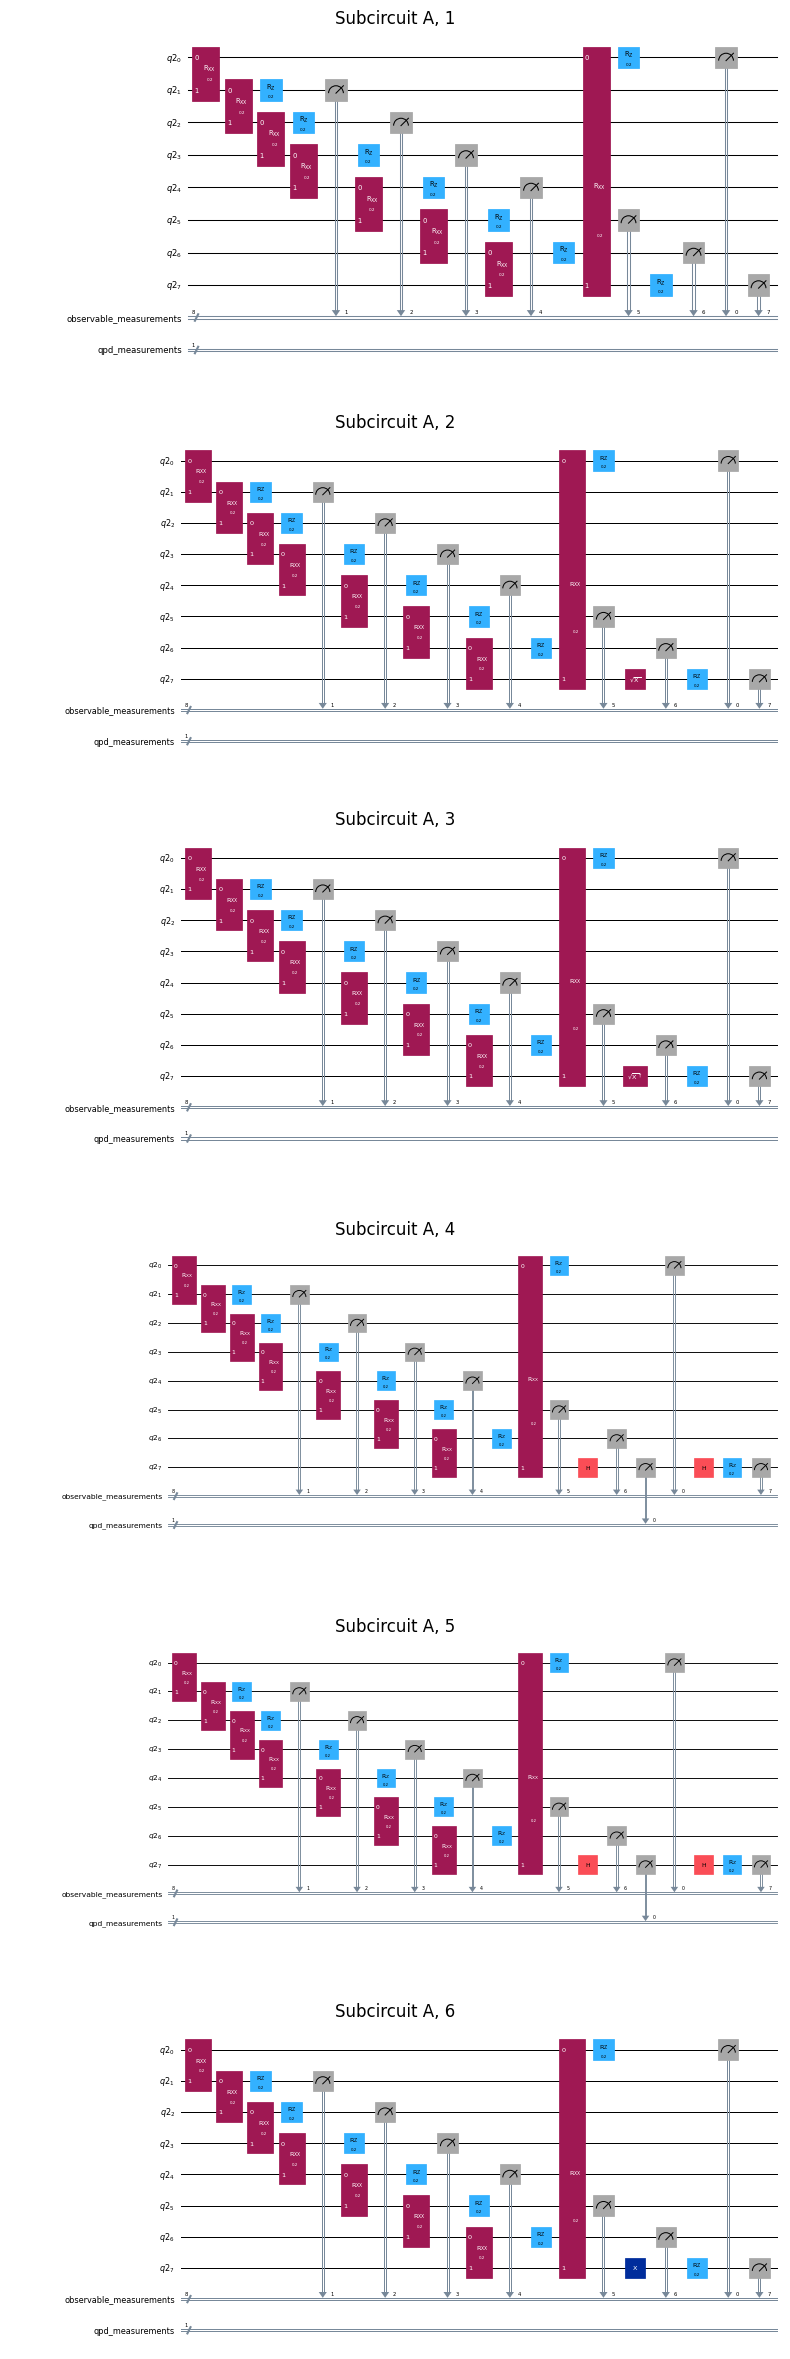

In [16]:
num_subplots = len(subexperiments['A'])

fig, axs = plt.subplots(nrows=num_subplots, ncols=1, figsize=(8, 4 * num_subplots))

if num_subplots == 1:
    axs = [axs]
    
for i, subcircuit in enumerate(subexperiments["B"]):
    subcircuit.draw('mpl', scale=0.8, fold=False, ax=axs[i])
    axs[i].set_title(f"Subcircuit A, {i+1}")

plt.tight_layout()
plt.show()


In [17]:
basis_gates = ["h", "rx", "ry", "rz", "rxx", "rzz", "ryy", "cnot"]
readable_data = []

for category in sorted(subexperiments.keys()):
    for index, circuit in enumerate(subexperiments[category]):
        transpiled = transpile(circuit, basis_gates=basis_gates)
        operations = []
        qubit_range = [transpiled.qubits[0]._index, transpiled.qubits[-1]._index]
        for instr in transpiled.data:
            # Get common values
            name = instr.operation.name
            angle = instr.operation.params
            qubits = [q._index for q in instr.qubits]
            # Skip measure operations not in qpd_measurements register
            if name == 'measure' and (
                not instr.clbits or
                instr.clbits[0]._register.name != 'qpd_measurements'
            ):
                continue
                
            operations.append({
                "Name": name,
                "Angle": angle,
                "Qubits": qubits
            })
        
        readable_data.append({
            "Subexperiment": category,
            "Subcircuit": index,
            "Qubit number": transpiled.num_qubits,
            "Qubit range": qubit_range,
            "Operations": operations
        })

with open("subcircuits.json", "w") as json_file:
    json.dump(readable_data, json_file, indent=4)

print("Subcircuits data has been successfully saved to 'subcircuits.json'.")

Subcircuits data has been successfully saved to 'subcircuits.json'.


In [18]:
transpiled.qubits[0]._index

8